
Processing folder: Aug '25\Aug 07 Exp\01 Aug\5S
Loading data from: Aug '25\Aug 07 Exp\01 Aug\5S
Loaded: 4000CE - 4500 rows
Loaded: 4000PE - 4500 rows
Loaded: 4050CE - 4447 rows
Loaded: 4050PE - 4500 rows
Loaded: 4100CE - 4496 rows
Loaded: 4100PE - 4500 rows
Loaded: 4150CE - 4330 rows
Loaded: 4150PE - 4500 rows
Loaded: 4200CE - 4499 rows
Loaded: 4200PE - 4500 rows
Loaded: 4250CE - 4499 rows
Loaded: 4250PE - 4500 rows
Loaded: 4300CE - 4500 rows
Loaded: 4300PE - 4500 rows
Loaded: 4350CE - 4498 rows
Loaded: 4350PE - 4500 rows
Loaded: 4400CE - 4500 rows
Loaded: 4400PE - 4500 rows
Loaded: 4450CE - 4500 rows
Loaded: 4450PE - 4500 rows
Loaded: 4500CE - 4500 rows
Loaded: 4500PE - 4500 rows
Loaded: 4550CE - 4500 rows
Loaded: 4550PE - 4500 rows
Loaded: 4600CE - 4500 rows
Loaded: 4600PE - 4500 rows
Loaded: 4650CE - 4500 rows
Loaded: 4650PE - 4500 rows
Loaded: 4700CE - 4500 rows
Loaded: 4700PE - 4500 rows
Loaded: 4750CE - 4500 rows
Loaded: 4750PE - 4500 rows
Loaded: 4800CE - 4500 rows
Loaded: 4800

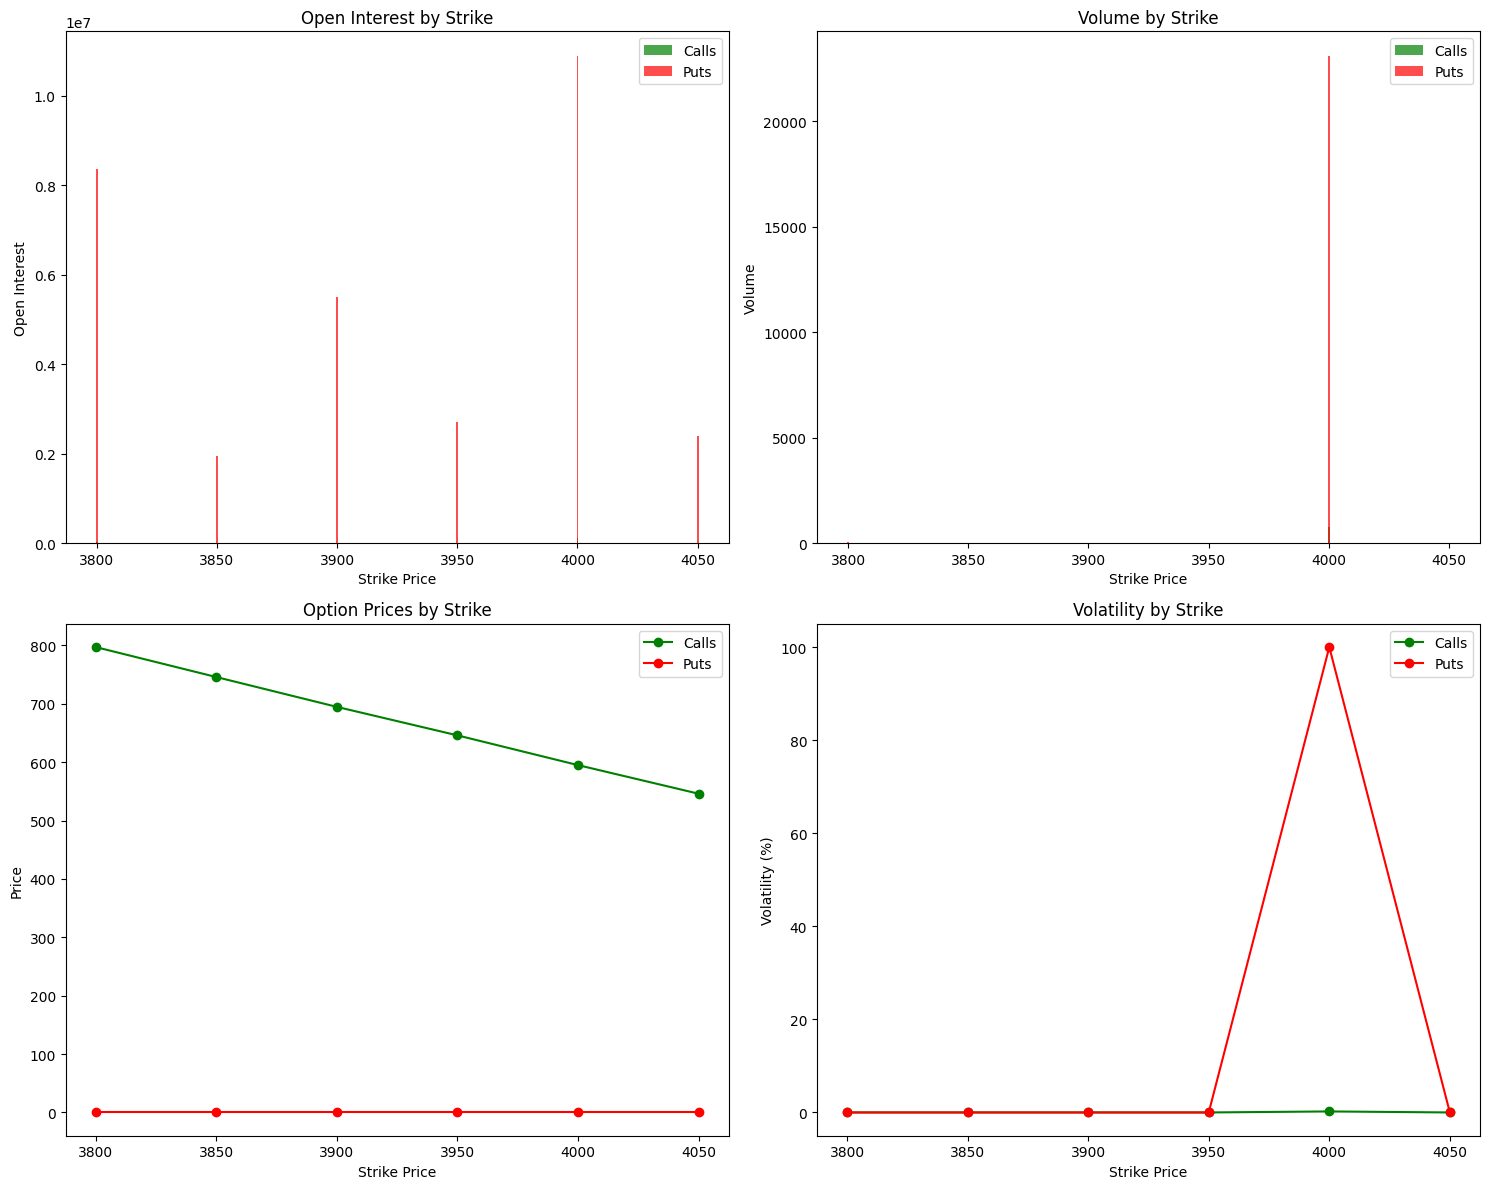

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

class NiftyOptionsAnalyzer:
    def __init__(self, base_path="Aug '25"):
        self.base_path = base_path
        self.data = {}
        self.futures_data = {}
        
    def load_data_from_folder(self, folder_path):
        """
        Load all options and futures data from a specific folder
        """
        print(f"Loading data from: {folder_path}")
        
        # Get all CSV files in the folder
        csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
        
        for file_path in csv_files:
            filename = os.path.basename(file_path)
            
            # Parse filename to extract strike and option type
            if 'nse_nifty' in filename and ('ce' in filename or 'pe' in filename):
                # Extract strike price and option type
                match = re.search(r'nse_nifty\d+(\d{4})(ce|pe)_min\.csv', filename)
                if match:
                    strike = int(match.group(1))
                    option_type = match.group(2).upper()
                    
                    # Load the data
                    df = pd.read_csv(file_path)
                    df['timestamp'] = pd.to_datetime(df['timestamp'])
                    df['strike'] = strike
                    df['option_type'] = option_type
                    
                    # Create key for storage
                    key = f"{strike}{option_type}"
                    self.data[key] = df
                    print(f"Loaded: {key} - {len(df)} rows")
                    
            elif 'nse_nifty' in filename and 'fut' in filename:
                # Load futures data
                df = pd.read_csv(file_path)
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                self.futures_data = df
                print(f"Loaded: NIFTY Futures - {len(df)} rows")
    
    def load_all_data(self):
        """
        Load data from all folders in the structure
        """
        # Find all 5S folders
        pattern = os.path.join(self.base_path, "**", "5S")
        folders = glob.glob(pattern, recursive=True)
        
        for folder in folders:
            print(f"\nProcessing folder: {folder}")
            self.load_data_from_folder(folder)
    
    def clean_data(self):
        """
        Clean and prepare the data for analysis
        """
        print("\nCleaning data...")
        
        # Clean options data
        for key, df in self.data.items():
            # Remove any rows with missing values
            df.dropna(inplace=True)
            
            # Ensure numeric columns are numeric
            numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'oi']
            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Remove rows with invalid prices (negative or zero)
            df = df[(df['open'] > 0) & (df['high'] > 0) & (df['low'] > 0) & (df['close'] > 0)]
            
            # Calculate additional metrics
            df['price_change'] = df['close'] - df['open']
            df['price_change_pct'] = (df['price_change'] / df['open']) * 100
            df['high_low_range'] = df['high'] - df['low']
            df['volatility'] = df['high_low_range'] / df['open'] * 100
            
            self.data[key] = df
        
        # Clean futures data
        if not self.futures_data.empty:
            self.futures_data.dropna(inplace=True)
            numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'oi']
            for col in numeric_cols:
                self.futures_data[col] = pd.to_numeric(self.futures_data[col], errors='coerce')
            
            self.futures_data = self.futures_data[
                (self.futures_data['open'] > 0) & 
                (self.futures_data['high'] > 0) & 
                (self.futures_data['low'] > 0) & 
                (self.futures_data['close'] > 0)
            ]
            
            # Calculate additional metrics for futures
            self.futures_data['price_change'] = self.futures_data['close'] - self.futures_data['open']
            self.futures_data['price_change_pct'] = (self.futures_data['price_change'] / self.futures_data['open']) * 100
            self.futures_data['high_low_range'] = self.futures_data['high'] - self.futures_data['low']
            self.futures_data['volatility'] = self.futures_data['high_low_range'] / self.futures_data['open'] * 100
    
    def get_strikes_available(self):
        """
        Get list of all available strike prices
        """
        strikes = set()
        for key in self.data.keys():
            strike = int(key[:-2])  # Remove CE/PE suffix
            strikes.add(strike)
        return sorted(list(strikes))
    
    def get_options_summary(self):
        """
        Get summary statistics for all options
        """
        summary_data = []
        
        for key, df in self.data.items():
            strike = int(key[:-2])
            option_type = key[-2:]
            
            summary = {
                'strike': strike,
                'option_type': option_type,
                'total_volume': df['volume'].sum(),
                'avg_oi': df['oi'].mean(),
                'max_oi': df['oi'].max(),
                'avg_price': df['close'].mean(),
                'max_price': df['close'].max(),
                'min_price': df['close'].min(),
                'avg_volatility': df['volatility'].mean(),
                'total_trades': len(df)
            }
            summary_data.append(summary)
        
        return pd.DataFrame(summary_data).sort_values(['strike', 'option_type'])
    
    def analyze_chain_at_timestamp(self, timestamp):
        """
        Analyze the entire options chain at a specific timestamp
        """
        chain_data = []
        
        for key, df in self.data.items():
            strike = int(key[:-2])
            option_type = key[-2:]
            
            # Get data for the specific timestamp
            time_data = df[df['timestamp'] == timestamp]
            
            if not time_data.empty:
                row = time_data.iloc[0]
                chain_data.append({
                    'strike': strike,
                    'option_type': option_type,
                    'open': row['open'],
                    'high': row['high'],
                    'low': row['low'],
                    'close': row['close'],
                    'volume': row['volume'],
                    'oi': row['oi'],
                    'price_change': row['price_change'],
                    'volatility': row['volatility']
                })
        
        return pd.DataFrame(chain_data).sort_values(['strike', 'option_type'])
    
    def get_put_call_ratio(self, timestamp=None):
        """
        Calculate Put-Call Ratio
        """
        if timestamp:
            chain_data = self.analyze_chain_at_timestamp(timestamp)
        else:
            # Use latest available timestamp
            latest_time = max([df['timestamp'].max() for df in self.data.values()])
            chain_data = self.analyze_chain_at_timestamp(latest_time)
        
        if chain_data.empty:
            return None
        
        # Calculate PCR
        call_volume = chain_data[chain_data['option_type'] == 'CE']['volume'].sum()
        put_volume = chain_data[chain_data['option_type'] == 'PE']['volume'].sum()
        
        call_oi = chain_data[chain_data['option_type'] == 'CE']['oi'].sum()
        put_oi = chain_data[chain_data['option_type'] == 'PE']['oi'].sum()
        
        return {
            'volume_pcr': put_volume / call_volume if call_volume > 0 else 0,
            'oi_pcr': put_oi / call_oi if call_oi > 0 else 0,
            'call_volume': call_volume,
            'put_volume': put_volume,
            'call_oi': call_oi,
            'put_oi': put_oi
        }
    
    def find_max_pain(self, timestamp=None):
        """
        Calculate Max Pain point
        """
        if timestamp:
            chain_data = self.analyze_chain_at_timestamp(timestamp)
        else:
            latest_time = max([df['timestamp'].max() for df in self.data.values()])
            chain_data = self.analyze_chain_at_timestamp(latest_time)
        
        if chain_data.empty:
            return None
        
        strikes = chain_data['strike'].unique()
        pain_points = []
        
        for strike in strikes:
            call_oi = chain_data[(chain_data['strike'] == strike) & 
                               (chain_data['option_type'] == 'CE')]['oi'].sum()
            put_oi = chain_data[(chain_data['strike'] == strike) & 
                              (chain_data['option_type'] == 'PE')]['oi'].sum()
            
            # Calculate pain for this strike
            pain = 0
            for s in strikes:
                if s < strike:
                    pain += call_oi * (strike - s)
                elif s > strike:
                    pain += put_oi * (s - strike)
            
            pain_points.append({'strike': strike, 'pain': pain})
        
        pain_df = pd.DataFrame(pain_points)
        max_pain_strike = pain_df.loc[pain_df['pain'].idxmin(), 'strike']
        
        return {
            'max_pain_strike': max_pain_strike,
            'pain_data': pain_df
        }
    
    def plot_chain_analysis(self, timestamp=None):
        """
        Plot options chain analysis
        """
        if timestamp:
            chain_data = self.analyze_chain_at_timestamp(timestamp)
        else:
            latest_time = max([df['timestamp'].max() for df in self.data.values()])
            chain_data = self.analyze_chain_at_timestamp(latest_time)
        
        if chain_data.empty:
            print("No data available for plotting")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: OI by Strike
        calls = chain_data[chain_data['option_type'] == 'CE']
        puts = chain_data[chain_data['option_type'] == 'PE']
        
        axes[0, 0].bar(calls['strike'], calls['oi'], alpha=0.7, label='Calls', color='green')
        axes[0, 0].bar(puts['strike'], puts['oi'], alpha=0.7, label='Puts', color='red')
        axes[0, 0].set_title('Open Interest by Strike')
        axes[0, 0].set_xlabel('Strike Price')
        axes[0, 0].set_ylabel('Open Interest')
        axes[0, 0].legend()
        
        # Plot 2: Volume by Strike
        axes[0, 1].bar(calls['strike'], calls['volume'], alpha=0.7, label='Calls', color='green')
        axes[0, 1].bar(puts['strike'], puts['volume'], alpha=0.7, label='Puts', color='red')
        axes[0, 1].set_title('Volume by Strike')
        axes[0, 1].set_xlabel('Strike Price')
        axes[0, 1].set_ylabel('Volume')
        axes[0, 1].legend()
        
        # Plot 3: Price by Strike
        axes[1, 0].plot(calls['strike'], calls['close'], 'o-', label='Calls', color='green')
        axes[1, 0].plot(puts['strike'], puts['close'], 'o-', label='Puts', color='red')
        axes[1, 0].set_title('Option Prices by Strike')
        axes[1, 0].set_xlabel('Strike Price')
        axes[1, 0].set_ylabel('Price')
        axes[1, 0].legend()
        
        # Plot 4: Volatility by Strike
        axes[1, 1].plot(calls['strike'], calls['volatility'], 'o-', label='Calls', color='green')
        axes[1, 1].plot(puts['strike'], puts['volatility'], 'o-', label='Puts', color='red')
        axes[1, 1].set_title('Volatility by Strike')
        axes[1, 1].set_xlabel('Strike Price')
        axes[1, 1].set_ylabel('Volatility (%)')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
    
    def get_time_series_analysis(self, strike, option_type):
        """
        Get time series analysis for a specific option
        """
        key = f"{strike}{option_type}"
        if key not in self.data:
            print(f"Data not available for {key}")
            return None
        
        df = self.data[key].copy()
        df.set_index('timestamp', inplace=True)
        
        # Calculate technical indicators
        df['sma_5'] = df['close'].rolling(window=5).mean()
        df['sma_20'] = df['close'].rolling(window=20).mean()
        df['rsi'] = self.calculate_rsi(df['close'])
        df['bollinger_upper'], df['bollinger_lower'] = self.calculate_bollinger_bands(df['close'])
        
        return df
    
    def calculate_rsi(self, prices, period=14):
        """
        Calculate RSI
        """
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """
        Calculate Bollinger Bands
        """
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, lower_band

# Usage example
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = NiftyOptionsAnalyzer()
    
    # Load all data
    analyzer.load_all_data()
    
    # Clean data
    analyzer.clean_data()
    
    # Get summary
    summary = analyzer.get_options_summary()
    print("\nOptions Summary:")
    print(summary)
    
    # Get available strikes
    strikes = analyzer.get_strikes_available()
    print(f"\nAvailable strikes: {strikes}")
    
    # Get PCR
    pcr = analyzer.get_put_call_ratio()
    print(f"\nPut-Call Ratio:")
    print(f"Volume PCR: {pcr['volume_pcr']:.3f}")
    print(f"OI PCR: {pcr['oi_pcr']:.3f}")
    
    # Find max pain
    max_pain = analyzer.find_max_pain()
    print(f"\nMax Pain Strike: {max_pain['max_pain_strike']}")
    
    # Plot analysis
    analyzer.plot_chain_analysis()